## Imports

In [226]:
import csv
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
from openai import OpenAI
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [166]:
DEFAULT_FONT = 14

In [167]:
# Load dataset
dataPath = './feedback-prize-english-language-learning/train.csv'
df_all = pd.read_csv(dataPath)

# Create essay average scores to simplify dataset comparisons
categories = df_all.columns[2:8]
predicted_columns = ['p_' + category for category in categories]
actual_columns = ['a_' + category for category in categories]
df_all['Average'] = df_all[categories].mean(axis=1).round(1)

In [168]:
# Split data into Train, Validation and Test sets
df_train, df_holdout = train_test_split(
    df_all, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(
    df_holdout, test_size=0.5, random_state=42)

# Create summary of all three datasets
train_desc = df_train['Average'].describe()
val_desc = df_val['Average'].describe()
test_desc = df_test['Average'].describe()

summary = pd.concat([train_desc, val_desc, test_desc], axis=1)
summary.columns = ['Train', 'Validate', 'Test']

print("\nSummary of Averages for each dataset:")
pd.set_option('display.float_format', lambda x: '%0.1f' % x)
display(summary)


Summary of Averages for each dataset:


,Train,Validate,Test
count,3128.0,391.0,392.0
mean,3.1,3.1,3.1
std,0.6,0.5,0.6
min,1.0,1.0,1.4
25%,2.7,2.7,2.7
50%,3.1,3.1,3.1
75%,3.5,3.4,3.5
max,5.0,4.6,4.8


## Generate Prompts

Function to generate k-shot prompts from example essays and an essay to evaluate.

In [169]:
def generate_prompt(scored_essay, example_essays=[], example_scores=[]):

    if len(example_essays) != len(example_scores):
        raise ValueError("Number of example essays and scores provided must match")

    INSTRUCTIONS = f"""Score the following essay in these categories: cohesion, syntax, vocabulary, phraseology, grammar, conventions. 
    Return only a JSON object with category scores between 1.0 and 5.0 is 0.5 increments. Do not include newlines or any other characters."""
    EXAMPLE_PREFIX = f""" Here is an example essay surrounded by triple backticks followed by scores: ```"""
    SCORED_ESSAY_PREFIX = f""" Essay for you to score surrounded by triple backticks: ```"""
    CATEGORIES = categories

    prompt = INSTRUCTIONS

    for e_ind, example in enumerate(example_essays):
        prompt += EXAMPLE_PREFIX
        prompt += example

        scores = "``` Score: "
        for s_ind, score in enumerate(example_scores[e_ind]):
            scores = scores + CATEGORIES[s_ind] + ": " + str(score) + ", "
        
        prompt += scores
    
    prompt += SCORED_ESSAY_PREFIX
    prompt += scored_essay
    prompt += "```"

    return prompt

In [170]:
test_essay1 = f""" Once, I walked down the empty street during midnight. """
example_1 = f"""Imagine someone that you know, that is trying to show you what maturity"""
example_2 = f"""They say that conserving energy and resources, some buissness have a four day"""
scores = [[1.0, 2.0, 3.0, 4.0, 5.0], [1.5, 2.5, 3.5, 4.5, 5.0]]
prompt = generate_prompt(test_essay1, [example_1, example_2], scores)
print(prompt)

Score the following essay in these categories: cohesion, syntax, vocabulary, phraseology, grammar, conventions. 
    Return only a JSON object with category scores between 1.0 and 5.0 is 0.5 increments. Do not include newlines or any other characters. Here is an example essay surrounded by triple backticks followed by scores: ```Imagine someone that you know, that is trying to show you what maturity``` Score: cohesion: 1.0, syntax: 2.0, vocabulary: 3.0, phraseology: 4.0, grammar: 5.0,  Here is an example essay surrounded by triple backticks followed by scores: ```They say that conserving energy and resources, some buissness have a four day``` Score: cohesion: 1.5, syntax: 2.5, vocabulary: 3.5, phraseology: 4.5, grammar: 5.0,  Essay for you to score surrounded by triple backticks: ``` Once, I walked down the empty street during midnight. ```


In [171]:
from constants import OPENAI_API_KEY

client = OpenAI(
    api_key=OPENAI_API_KEY
)

def get_completion(prompt, model="gpt-3.5-turbo"):

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model=model,
    )

    return chat_completion.choices[0].message.content

In [172]:
import json

def convert_json_to_list(json_input):
    try:
        # Strip everything before the first '{' and after the last '}'
        json_input = json_input[json_input.find("{"):]
        json_input = json_input[:json_input.rfind("}") + 1]

        data = json.loads(json_input)
        values = list(data.values())
        return values
    except json.JSONDecodeError:
        print("Invalid JSON input")
        return []

In [173]:
output = get_completion(generate_prompt(test_essay1))

print(convert_json_to_list(output))

[3.5, 4.0, 3.0, 3.5, 4.0, 4.0]


In [174]:
def collect_results(model, filename, example_essays=[], example_scores=[]):
    # Create file to record results if not yet created
    if not os.path.exists(filename):
        with open(filename, 'w') as csvfile:
            header = ['text_id'] + actual_columns + predicted_columns
            csv.writer(csvfile).writerow(header)

    #Get the next row needed to be processed
    with open(filename, 'r') as outfile:
        start = len(list(csv.reader(outfile))) - 1

    end = len(df_test) - 1

    for idx in tqdm(range(start, end)):
        id = df_test.iloc[idx]['text_id']
        essay = df_test.iloc[idx]['full_text']
        actual_scores = list(df_test.iloc[idx][categories].values)
        predicted_scores = convert_json_to_list(
            get_completion(
                generate_prompt(essay, example_essays=example_essays, example_scores=example_scores),
                model=model
            )
        )

        with open(filename, 'a') as outfile:
            writer = csv.writer(outfile)
            writer.writerow([id] + actual_scores + predicted_scores)

print(df_test.head(10))

           text_id                                          full_text  \
1621  7B2B2910BB90  Imagine you are going to buy some new shoes bu...   
1204  5D693DD9978D  How will be high school different if you will ...   
3412  EA4AED3BFE34  Some schools permit their students use cellpho...   
291   15968BD9B40A  Some schools have programs where younger stude...   
2988  D6504339A690  The reason its good to ask more than one perso...   
1812  888A04678CCA  Some School districts programs want to graduat...   
3362  E8445DB18983  Scientist Albert Eisnste sad " imagination is ...   
810   3EA2BA9DAB33  Well i thik that is a good idea for all the st...   
2650  C41E40F2D803  Do you know how many careers' choices you have...   
3506  EF455BB07922  The grow is the stage of the life on the grow-...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  Average  
1621       2.5     2.5         3.0          2.5      3.5          3.5      2.9  
1204       3.0     2.5         3.0

In [175]:
def get_individual_score(text_id, model="gpt-3.5-turbo-1106", example_essays = [], example_scores = []):
    target_text = df_test['full_text'][df_test['text_id'] == text_id]
    scores = get_completion(generate_prompt(target_text.values[0], example_essays=example_essays, example_scores=example_scores),
                            model=model)
    print(scores)
    print(convert_json_to_list(scores))

In [176]:
def get_example_essays(targets, df):
    example_essays = []
    example_scores = []
    for target in targets:
        example = df.iloc[(df['Average'] - target).abs().argmin()]
        #print(example)
        example_essays.append(example['full_text'])
        example_scores.append(example[categories].values.tolist())
    return example_essays, example_scores

five_shot_essays, five_shot_scores = get_example_essays([1, 2, 3, 4, 5], df_train)

one_shot_essay, one_shot_scores = get_example_essays([3], df_train) 

#print(generate_prompt(test_essay1, example_essays=one_shot_essay, example_scores=one_shot_scores))

#print(get_individual_score('D6504339A690'))
print(get_individual_score('EA4AED3BFE34', model='gpt-4-1106-preview'))
#print(get_individual_score('CC0186CE98B3', model='gpt-3.5-turbo-1106', example_essays=one_shot_essay, example_scores=one_shot_scores))
#print(get_individual_score(text_id='F1DF4F89F70D', model='gpt-3.5-turbo-1106', example_essays=five_shot_essays, example_scores=five_shot_scores))

```json
{
  "cohesion": 2.5,
  "syntax": 2.0,
  "vocabulary": 2.5,
  "phraseology": 2.0,
  "grammar": 2.0,
  "conventions": 1.5
}
```
[2.5, 2.0, 2.5, 2.0, 2.0, 1.5]
None


In [242]:
#collect_results("gpt_zero_shot.csv")
#collect_results("GPT3.5-1-Shot-Delimited.csv", example_essays=one_shot_essay, example_scores=one_shot_scores)
#collect_results('gpt-4-1106-preview', "GPT4-1-Shot-1106.csv", example_essays=one_shot_essay, example_scores=one_shot_scores)
collect_results('gpt-4-1106-preview', "GPT4-5-Shot-1106.csv", example_essays=five_shot_essays, example_scores=five_shot_scores)
#collect_results('gpt-3.5-turbo-1106', "GPT3.5-1-Shot-1106.csv", example_essays=one_shot_essay, example_scores=one_shot_scores)
#collect_results('gpt-3.5-turbo-1106', "GPT3.5-5-Shot-1106.csv", example_essays=five_shot_essays, example_scores=five_shot_scores)

 66%|██████▌   | 134/203 [07:26<03:50,  3.33s/it]


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-1106-preview in organization org-GZzS1FXU0iqkoccy64qcWd7T on tokens per day (TPD): Limit 500000, Used 499249, Requested 4221. Please try again in 9m59.616s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [209]:
# Function to calculate loss
def analyze_results(filename):

    title = filename.rsplit('.', 1)[0]

    MIN_VALUE = 1
    MAX_VALUE = 5
    
    df = pd.read_csv(filename)

    df['a_overall'] = df[actual_columns].mean(axis=1)
    df['p_overall'] = df[predicted_columns].mean(axis=1)
    
    # Dataframe of individual category scores
    df_RMSE = pd.DataFrame(columns=['Category', title])

    all_categories = categories.values.tolist()

    for category in all_categories:
        y_true = df['a_' + category]
        y_pred = df['p_' + category]
        df_RMSE.loc[len(df_RMSE)] = [category, mean_squared_error(y_true, y_pred, squared=False)]
    
    # Insert average RMSE as first row
    overall_average = df_RMSE[title].mean()
    new_row = {'Category': 'overall', title: overall_average}
    new_row_df = pd.DataFrame(new_row, index=[0])
    df_RMSE = pd.concat([new_row_df, df_RMSE]).reset_index(drop=True)

    # Plot average actual vs predicitons
    plt.scatter(df['a_overall'], df['p_overall'])
    plt.plot([MIN_VALUE, MAX_VALUE], [MIN_VALUE, MAX_VALUE], color='red')
    plt.legend(['Predictions', 'Perfect Correlation'])
    plt.title(title + ' Predicted vs. Actual Average Scores')
    plt.show()

    return df_RMSE

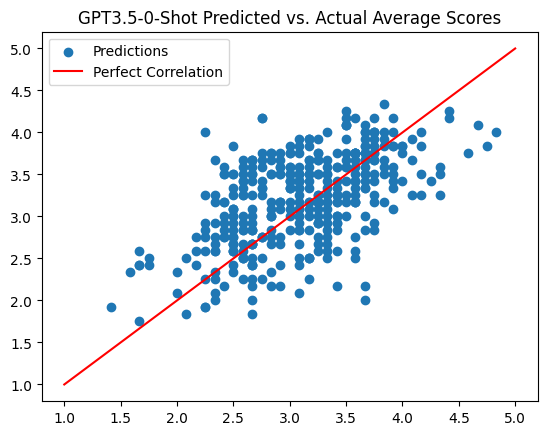

,Category,GPT3.5-0-Shot
0,overall,0.734
1,cohesion,0.834
2,syntax,0.715
3,vocabulary,0.659
4,phraseology,0.706
5,grammar,0.759
6,conventions,0.732


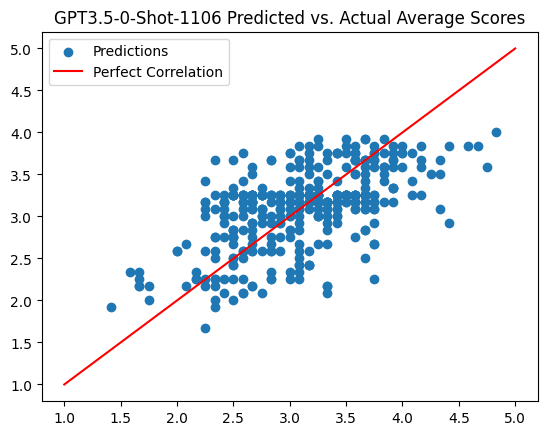

,Category,GPT3.5-0-Shot-1106
0,overall,0.659
1,cohesion,0.667
2,syntax,0.634
3,vocabulary,0.623
4,phraseology,0.684
5,grammar,0.662
6,conventions,0.684


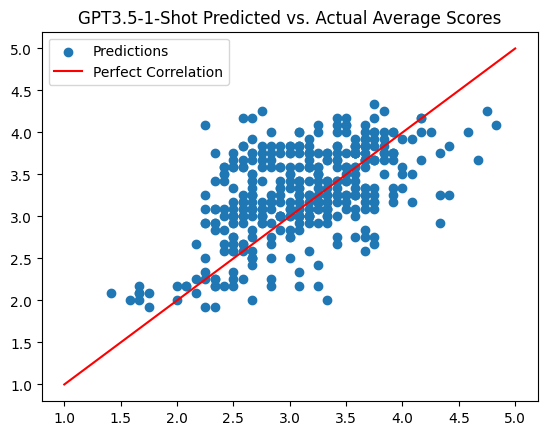

,Category,GPT3.5-1-Shot
0,overall,0.713
1,cohesion,0.741
2,syntax,0.773
3,vocabulary,0.610
4,phraseology,0.696
5,grammar,0.748
6,conventions,0.710


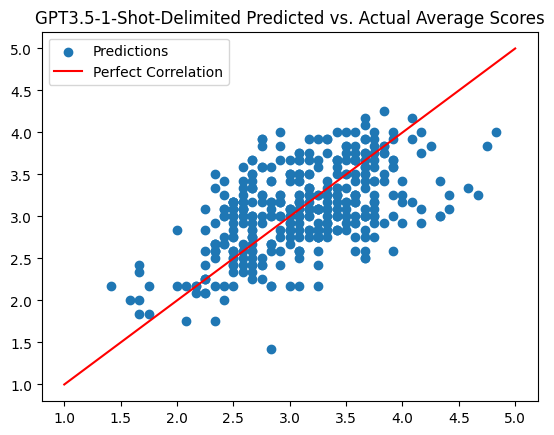

,Category,GPT3.5-1-Shot-Delimited
0,overall,0.684
1,cohesion,0.716
2,syntax,0.678
3,vocabulary,0.612
4,phraseology,0.697
5,grammar,0.710
6,conventions,0.693


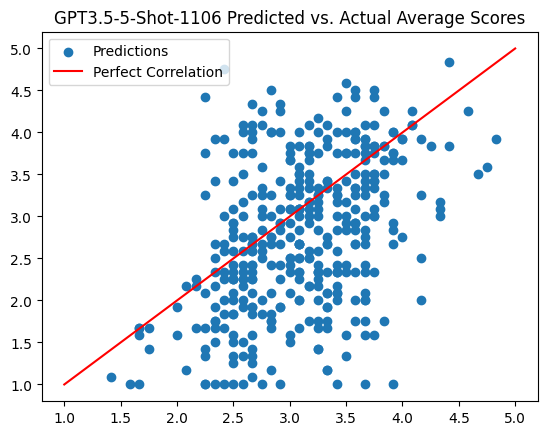

,Category,GPT3.5-5-Shot-1106
0,overall,1.005
1,cohesion,1.076
2,syntax,0.985
3,vocabulary,1.001
4,phraseology,1.023
5,grammar,0.995
6,conventions,0.948


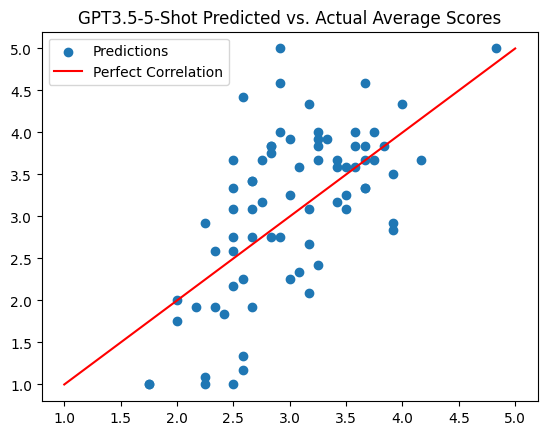

,Category,GPT3.5-5-Shot
0,overall,0.876
1,cohesion,0.945
2,syntax,0.881
3,vocabulary,0.757
4,phraseology,0.841
5,grammar,0.945
6,conventions,0.885


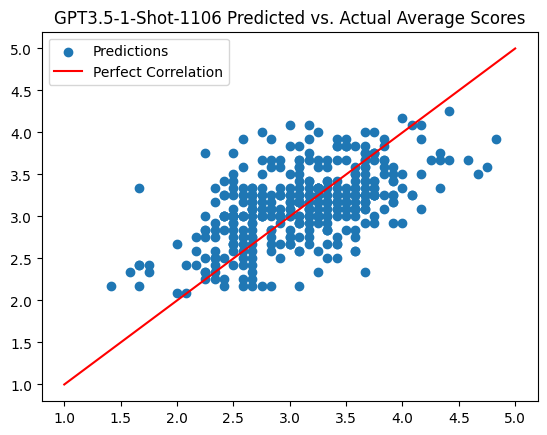

,Category,GPT3.5-1-Shot-1106
0,overall,0.664
1,cohesion,0.646
2,syntax,0.682
3,vocabulary,0.597
4,phraseology,0.666
5,grammar,0.723
6,conventions,0.670


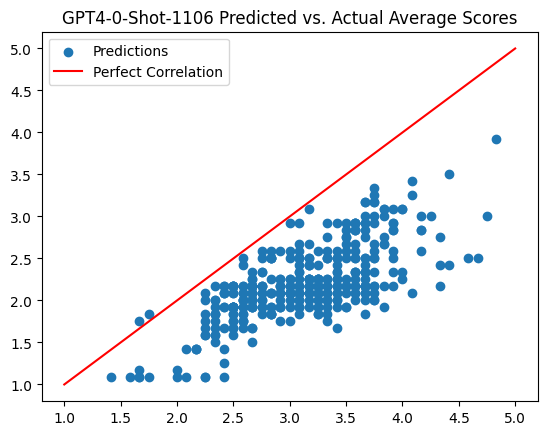

,Category,GPT4-0-Shot-1106
0,overall,1.065
1,cohesion,0.917
2,syntax,0.977
3,vocabulary,0.842
4,phraseology,1.127
5,grammar,1.229
6,conventions,1.297


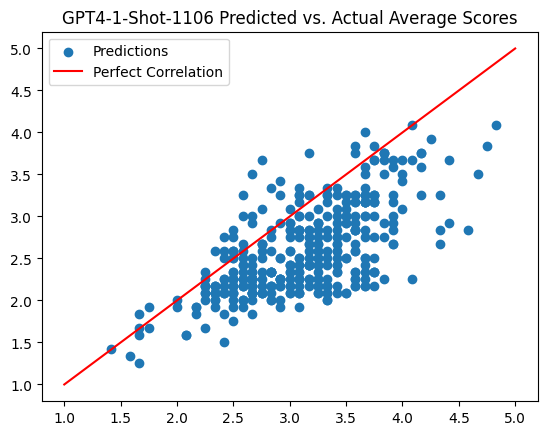

,Category,GPT4-1-Shot-1106
0,overall,0.792
1,cohesion,0.744
2,syntax,0.672
3,vocabulary,0.637
4,phraseology,0.896
5,grammar,0.950
6,conventions,0.855


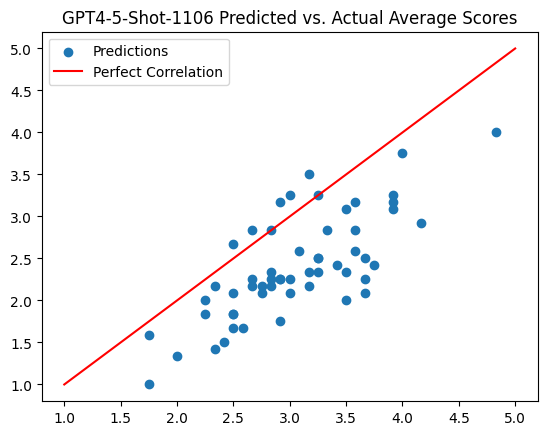

,Category,GPT4-5-Shot-1106
0,overall,0.875
1,cohesion,0.765
2,syntax,0.750
3,vocabulary,0.788
4,phraseology,0.933
5,grammar,1.029
6,conventions,0.984


In [210]:
pd.set_option('display.float_format', lambda x: '%0.3f' % x)

display(analyze_results("GPT3.5-0-Shot.csv"))
display(analyze_results("GPT3.5-0-Shot-1106.csv"))
display(analyze_results("GPT3.5-1-Shot.csv"))
display(analyze_results("GPT3.5-1-Shot-Delimited.csv"))
display(analyze_results("GPT3.5-5-Shot-1106.csv"))
display(analyze_results("GPT3.5-5-Shot.csv"))
display(analyze_results("GPT3.5-1-Shot-1106.csv"))
display(analyze_results("GPT4-0-Shot-1106.csv"))
display(analyze_results("GPT4-1-Shot-1106.csv"))
display(analyze_results("GPT4-5-Shot-1106.csv"))


In [211]:
# Analyze fine-tuning analyze_results





,Run,lr_start,lr_decay,epoch_decay,batch_size,dropout,epochs,Type,1,2,3,4,5,6,7,8,9,10
0,1.000,0.000,1.000,1.000,8.000,0.000,10.000,train,1.009,0.569,0.567,0.533,0.489,0.475,0.467,0.461,0.454,0.449
1,1.000,0.000,1.000,1.000,8.000,0.000,10.000,val,0.572,0.597,0.568,0.528,0.532,0.509,0.511,0.506,0.505,0.501
2,1.000,0.000,0.900,1.000,8.000,0.000,10.000,train,1.204,0.552,0.531,0.521,0.510,0.503,0.496,0.490,0.481,0.480
3,1.000,0.000,0.900,1.000,8.000,0.000,10.000,val,0.570,0.553,0.546,0.531,0.521,0.528,0.523,0.521,0.518,0.519
4,2.000,0.000,0.700,1.000,8.000,0.000,10.000,train,2.093,0.679,0.608,0.575,0.558,0.547,0.538,0.536,0.535,0.530


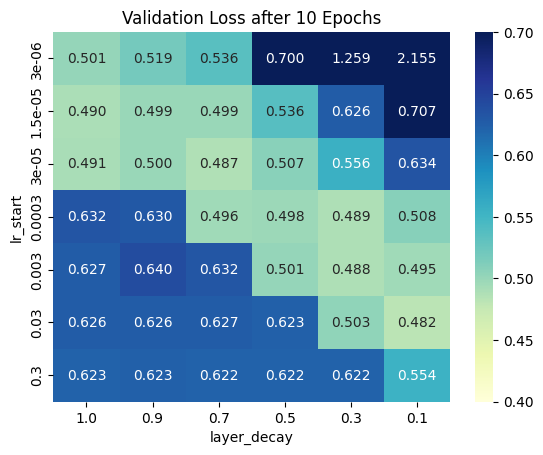

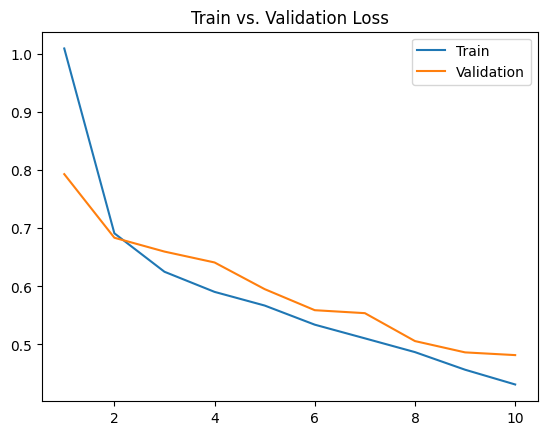

[0.793311018, 0.683802451, 0.659971315, 0.641230506, 0.595306473, 0.559032426, 0.553940297, 0.505855301, 0.486398834, 0.481702018]


In [239]:
df_fine_tuned = pd.read_csv("Fine-Tuning-Results.csv")

df_val = df_fine_tuned[df_fine_tuned['Type'] == 'val']

df_val_pivot = df_val.pivot(index='lr_start', columns='layer_decay', values='10')

df_val_pivot = df_val_pivot[df_val_pivot.columns[::-1]]

sns.heatmap(df_val_pivot, annot=True, fmt=".3f", cmap="YlGnBu", vmin=0.4, vmax=0.7)
plt.title("Validation Loss after 10 Epochs")

plt.show()

# Display train versus validation loss
train_results = df_fine_tuned.iloc[70][7:].to_list()[1:]
val_results = df_fine_tuned.iloc[71][7:].to_list()[1:]

x = [i for i in range(1, len(train_results) + 1)]

plt.plot(x, train_results)
plt.plot(x, val_results)
plt.legend(['Train', 'Validation'])
plt.title("Train vs. Validation Loss")
plt.show()

